<img src="../../img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

# Topic Modeling With BERTopic

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Use BERTopic to group r/AmItheAsshole submissions by the issues people write about.
* Interpret and visualize the topics found by the model.
* Try out ways to improve or simplify the model when topics overlap too much or don’t make sense.
* Practice naming and describing topics, and using them to organize or classify new text.
</div>

### Icons Used in This Notebook
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>

### Sections
1. [Topic Modeling with BERTopic](#topic)
2. [Explore Selected Topics](#explore)
3. [Reducing Overlap](#reduce)
4. [Finding Representative Posts](#repr)


<a id='topic'></a>

# Topic Modeling with BERTopic

In this optional notebook, we explore **BERTopic**, a topic modeling tool that leverages BERT embeddings and [c-TF-IDF](https://maartengr.github.io/BERTopic/api/ctfidf.html), to extract topics. It is a more "modern" topic modeling approach than the one we explore in our other notebook, and it can be interesting to compare topic model outputs between the approaches!

## About BERT Embeddings
BERT embeddings are vector representations of text created by the BERT model, which is a large transformer-based neural network trained to understand language context. Unlike traditional word embeddings (like word2vec), BERT creates contextual embeddings. That means the same word will have different vector representations depending on its surrounding words. BERT processes entire sentences at once, using its attention mechanism to capture meaning and relationships between words.

BERTopic works as follows:

- **Understands text using BERT:**  
Instead of just counting words, BERTopic uses a language model (BERT or similar) to turn each document into a “vector”—a list of numbers that captures its meaning and context. This makes it better at grouping together texts that talk about similar things, even if they use different words.

- **Clusters similar documents:**  
BERTopic then looks for clusters (groups) of documents that are close to each other in this vector space. It uses an algorithm called **HDBSCAN** that decides, based on the data, how many clusters (topics) make sense. This means you don’t have to guess the number of topics in advance.

- **Finds key words for each topic:**  
For every cluster it finds, BERTopic looks for the most important words that make this group unique compared to the rest of your data. These words help you quickly understand what each topic is about.

- **Visualizes topics and documents:**  
BERTopic comes with interactive tools to show you how your topics relate to each other, how common each topic is, and where your documents fit in.

### Note on package installation
This cell makes sure all the Python packages needed for this lesson are installed.
If you’re working on Datahub, you might not have everything yet.
Running this cell will check for each package and install it if it’s missing, so your notebook runs smoothly.

- If you are running this notebook on **DataHub**, you may need to **uncomment and run** the `%pip install ...` line below if you get an error about a missing package. Restart your kernel after running this cell!
- If you are working **locally** (on your own computer), you should already have all required packages installed via your Conda environment (see the ***"Local Python and Jupyter Setup"*** page on bCourses). Only use the `pip install` line if you see an ImportError and know what you’re doing.

In [1]:
# restart kernel after running
#%pip install bertopic 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.7 MB/s eta 0:00:00m eta 0:00:010:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 4.8 MB/s eta 0:00:00m eta 0:00:010:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 7.2 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.0/358.0 kB 2.5 MB/s eta 0:00:001.9 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01m
  Created wheel for hdbscan: filename=hdbscan-0

**Note: this notebook might not work on your local machine depending on your system architecture. It does work on DataHub, however.**

## Loading the Data

In [1]:
import gdown

gdown.download("https://drive.google.com/uc?id=1Glac4spXraWRcC_loxu1Cu4Bw-szS2ou", "../../data/aita_pp.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Glac4spXraWRcC_loxu1Cu4Bw-szS2ou
To: /Users/tomvannuenen/Library/CloudStorage/Dropbox/GitHub/DEV/DIGHUM160/data/aita_pp.csv
100%|██████████████████████████████████████| 56.6M/56.6M [00:01<00:00, 30.2MB/s]


'../../data/aita_pp.csv'

In [2]:
import pandas as pd

# Load your preprocessed AITA CSV (change the filename if needed)
df = pd.read_csv('../../data/aita_pp.csv')

In [3]:
docs = df['pp_text'].tolist()

## Build and Fit BERTopic Model
We'll use default settings first. This may take a few minutes.

In [8]:
from bertopic import BERTopic

# Use only a subset for demo to avoid memory errors
docs_sample = docs[:1000]

topic_model = BERTopic(verbose=True)
topics, probabilities = topic_model.fit_transform(docs_sample)

2025-06-01 15:34:46,931 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-06-01 15:34:54,055 - BERTopic - Embedding - Completed ✓
2025-06-01 15:34:54,055 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-01 15:34:55,409 - BERTopic - Dimensionality - Completed ✓
2025-06-01 15:34:55,410 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-01 15:34:55,434 - BERTopic - Cluster - Completed ✓
2025-06-01 15:34:55,436 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-01 15:34:55,531 - BERTopic - Representation - Completed ✓


<a id='explore'></a>

# Explore Extracted Topics
View topic frequencies and the top words per topic.

In [9]:
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,457,-1_told_like_said_time,"[told, like, said, time, want, got, know, goin...",[throwaway_account ask question following stor...
1,0,133,0_like_told_friends_said,"[like, told, friends, said, sex, girlfriend, g...",[start freaking want fully support women men a...
2,1,57,1_family_brother_mom_sister,"[family, brother, mom, sister, told, dad, moth...",[hello r aita throwaway hope obvious_reasons p...
3,2,40,2_pay_money_son_kids,"[pay, money, son, kids, daughter, paying, coll...",[daughter turning weeks starting college fall ...
4,3,38,3_pregnant_pregnancy_baby_abortion,"[pregnant, pregnancy, baby, abortion, want, ch...",[start know sounds bad try explain 21(m girlfr...
5,4,35,4_seat_people_like_asshole,"[seat, people, like, asshole, seats, said, car...",[happened hours ago thinking today important t...
6,5,33,5_daughter_wife_ex_life,"[daughter, wife, ex, life, kids, divorce, year...",[recently won fuck money wo exactly millions m...
7,6,30,6_tip_card_pay_money,"[tip, card, pay, money, manager, bill, said, c...",[months_ago trusty corolla totaled accident th...
8,7,24,7_teacher_class_students_school,"[teacher, class, students, school, told, kids,...",[teach private school affiliated religion allo...
9,8,21,8_vegan_meat_food_vegetarian,"[vegan, meat, food, vegetarian, eat, cook, eat...",[year_old mom year_old daughter vegan years si...


💡 **Tip**: Topic -1 in BERTopic is a “catch-all” for documents that don’t fit into any meaningful cluster.

This works as follows:
- HDBSCAN (the clustering algorithm) automatically labels “noise” or “outlier” documents with -1.
- These are typically posts that are too unique, too generic, or just don’t belong to any clear topic group.
- Including topic -1 in your list of topics will show a “topic” that’s not really coherent, and the top words for -1 are usually either very generic or meaningless.
- Most users ignore topic -1 when reviewing topics and top words, focusing only on the numbered topics (0, 1, 2, …).

In [12]:
# How many topics do we have?
topic_info.shape

(19, 5)

In [13]:
# Show top words for topic 0
topic_model.get_topic(0)

[('like', 0.02507704221384434),
 ('told', 0.02399830284838897),
 ('friends', 0.023790884325017782),
 ('said', 0.023728767658156673),
 ('sex', 0.019643105658573815),
 ('girlfriend', 0.01945963175664632),
 ('guy', 0.017785438928531877),
 ('relationship', 0.01772901522714186),
 ('feel', 0.017230118155244993),
 ('asked', 0.016719639061031785)]

## Intertopic Distance Map
The `visualize_topics` function visualizes topics and their similarity in an interactive plot. We're also saving it to disk so it can be embedded on a website.

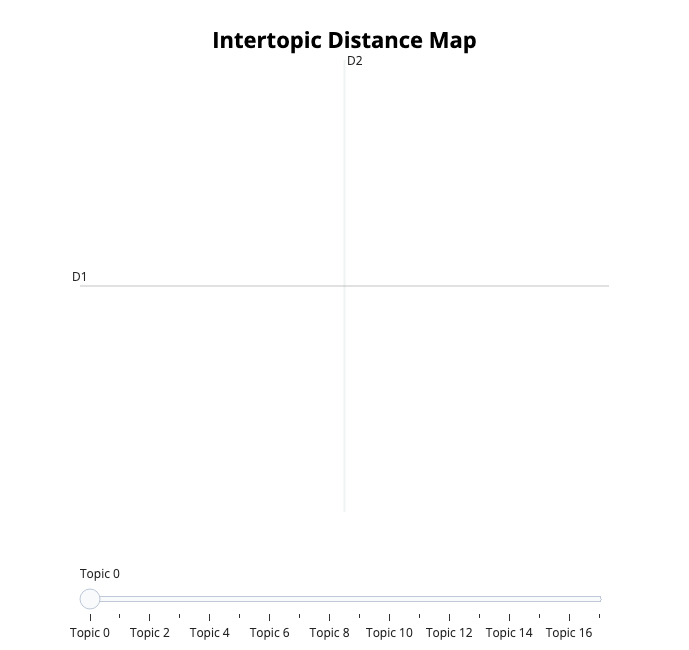

In [22]:
fig = topic_model.visualize_topics()
fig.write_html("bertopic_topics.html") 
fig.show()

<a id='reduce'></a>

# Reducing Overlap

If your intertopic distance map shows lots of overlapping bubbles, your model may have produced **too many fine-grained topics**. This is common with large or complex datasets! Similar documents can get split into clusters that aren't really distinct.

To make your topics broader and reduce overlap, you can **merge similar topics** using the `.reduce_topics()` method in BERTopic.

### How to Reduce the Number of Topics

Use the following code to merge topics until only your desired number remain (e.g., 15):

In [19]:
# Reduce the number of topics (set to the number you want)
target_num_topics = 10  # change this as needed
topic_model.reduce_topics(docs, nr_topics=target_num_topics)

# Re-visualize the intertopic distance map
fig = topic_model.visualize_topics()

fig.write_html(f"bertopic_topics_{target_num_topics}.html")
fig.show()

ValueError: All arrays must be of the same length

As you can tell, we no longer have so many overlapping topics. That's good!

## Visualizing Topic Frequencies
Let's create a bar chart of most common topics (excluding outliers).

    Topic  Count                              Name
1       0   3112       0_wedding_told_said_brother
2       1    658             1_money_work_pay_home
3       2    646           2_dog_cat_dogs_roommate
4       3    607             3_food_eat_vegan_meat
5       4    509         4_work_office_manager_job
6       5    409        5_friends_friend_said_like
7       6    193             6_hair_cut_long_shave
8       7    173  7_class_teacher_students_student
9       8    166    8_white_language_asian_culture
10      9    134   9_gifts_gift_birthday_christmas


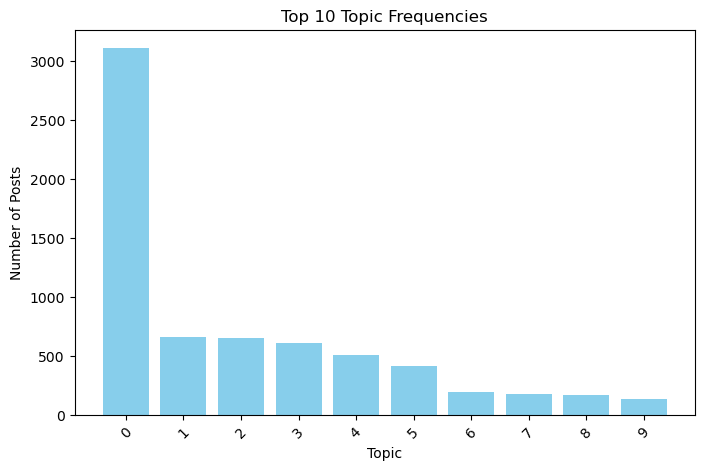

In [33]:
import matplotlib.pyplot as plt

freq_df = topic_model.get_topic_info()
freq_df = freq_df[freq_df.Topic != -1]   # remove outlier topic -1
freq_df = freq_df.sort_values('Count', ascending=False)
top_n = 10
freq_top_n = freq_df.head(top_n)
print(freq_top_n[['Topic', 'Count', 'Name']])

plt.figure(figsize=(8,5))
plt.bar(range(len(freq_top_n)), freq_top_n['Count'], color='skyblue')
plt.xticks(range(len(freq_top_n)), [str(t) for t in freq_top_n['Topic']], rotation=45)
plt.title(f'Top {top_n} Topic Frequencies')
plt.xlabel('Topic')
plt.ylabel('Number of Posts')
plt.savefig(f"top_{top_n}_topic_frequencies.png", dpi=300)
plt.show()

<a id='repr'></a>

# Finding Representative Posts

We can use BERTopic to find representative posts for a topic. So if you're interested in exploring posts from a particular topic, this is how you do that.

Let's first look at the top words for each topic:

In [34]:
for topic_num in topic_model.get_topic_info().Topic:
    if topic_num == -1:
        continue  # skip the outlier topic if you want
    top_words = [word for word, _ in topic_model.get_topic(topic_num)]
    print(f"Topic {topic_num}: {', '.join(top_words)}")

Topic 0: wedding, told, said, brother, family, mom, sister, dad, want, got
Topic 1: money, work, pay, home, house, time, kids, daughter, husband, wife
Topic 2: dog, cat, dogs, roommate, like, house, said, home, cats, told
Topic 3: food, eat, vegan, meat, weight, eating, like, said, cook, told
Topic 4: work, office, manager, job, said, company, boss, people, told, like
Topic 5: friends, friend, said, like, told, guy, gay, girlfriend, people, know
Topic 6: hair, cut, long, shave, like, daughter, said, look, haircut, told
Topic 7: class, teacher, students, student, school, professor, grade, said, told, teachers
Topic 8: white, language, asian, culture, irish, english, racist, speak, accent, japanese
Topic 9: gifts, gift, birthday, christmas, year, got, like, said, family, presents
Topic 10: son, said, school, wife, kids, kid, told, like, home, got
Topic 11: clothes, wear, wearing, bra, bras, like, dress, size, boobs, shirt
Topic 12: boyfriend, time, like, said, work, bf, cook, job, home, 

Let's say I'm interested in topic 6, which (in my case) seems to be about haircuts.

**⚠️ Warning:** If you run this code again your topics might look different due to the probabilistic nature of UMAP. 

In [36]:
topic_num = 6  # pick any topic number you see in topic_info
examples = topic_model.get_representative_docs(topic_num)
for i, doc in enumerate(examples[:3]):  # show up to 3 examples
    print(f"Example {i+1} for topic {topic_num}:\n", doc, "\n")

Example 1 for topic 6:
 m gf f. waist length brown hair looks great takes care hair lot look way complains frequently hair hard way heavy starting headaches hard brush etc tell bun times way past week started talking lot getting trim rid dry ends problem hair needs trimmed anyways days_ago work work came home look bathroom knocked_door said come surprisei walk bathroom hair completely butchered relevant cosmetology knowledge hair cutting know little shorter bob length tried type layers think botched karen hair cut uneven inch half bangs tried choppy literally poking eye uneven parts hair longer help stand cringe looked bad told straight salon fixed pay going lie told looks horrible genuinely happy new hair cut disbelief got upset like long hair told case completely botched hair mad saying hair looks horrible idk aita 

Example 2 for topic 6:
 yesterday haircut time forever obvious_reasons hair long thick getting tangled constantly trim needed went salon stylist agreed length wanted che